# GT4Py Concepts

This notebook walks through the major concepts of the [GT4Py](https://github.com/GridTools/gt4py) stencil library. The concepts are exposed with the aid of some illustrative examples which are particularly relevant in weather and climate.

In [3]:
import gt4py as gt
from gt4py import gtscript
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["font.size"] = 16

/users/class170/HPC4WC_venv/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Defining a stencil computation

Horizontal advection by the mean flow represents a major driving force for atmospheric dynamics. Consider the conserved quantity $\phi = \rho \psi$, where $\rho$ is the air density and $\psi$ a specific quantity. Its transport by the steering wind $(u, \, v)$ is governed by the equation

\begin{equation}
    \frac{\partial \phi}{\partial t} + \frac{\partial u \phi}{\partial x} + \frac{\partial v \phi}{\partial y} = 0 \, .
\end{equation}

(Observe that $\psi \equiv 1$ discloses the continuity equation.) An established way to discretize this equation on a Cartesian grid is by centered spatio-temporal differencing:

\begin{equation}
    \frac{\phi^{n+1}_{i,j} - \phi^{n-1}_{i,j}}{2 \Delta t} + \frac{u_{i+1,j}^n \, \phi_{i+1,j}^n  -  u_{i-1,j}^n \, \phi_{i-1,j}^n}{2 \Delta x} + \frac{v_{i,j+1}^n \, \phi_{i,j+1}^n - v_{i,j-1}^n \, \phi_{i,j-1}^n}{2 \Delta y} = 0 \, .
\end{equation}

This method is commonly known as the leapfrog scheme. Here $\Delta x$ and $\Delta y$ are the grid spacings in the $x$- and $y$-direction, $\Delta t$ is the time-step and for a generic variable $\xi = \xi(x, \, y, \, t)$ we denote by $\xi_{i,j}^n$ the numerical approximation of $\xi(i \Delta x, \, j \Delta y, \, n \Delta t)$. 

![grid](img/grid.png)

The formula which advances the solution forward in time is found to be

\begin{equation}
    \phi_{i,j}^{n+1} = \phi_{i, j}^{n-1} - \frac{\Delta t}{\Delta x} \left( u_{i+1,j}^n \, \phi_{i+1,j}^n - u_{i-1,j}^n \, \phi_{i-1,j}^n \right) - \frac{\Delta t}{\Delta y} \left( v_{i,j+1}^n \, \phi_{i,j+1}^n - v_{i,j-1}^n \, \phi_{i,j-1}^n  \right) \, .
\end{equation}

We recognize the update operator as a stencil computation. The field $\phi^{n+1}$ at $(i, \, j)$ (blue point in the figure below) is computed by accessing $\phi^{n-1}$ at $(i, \, j)$ and $\phi^n$, $u^n$ and $v^n$ at the neignboring points $(i-1, \, j)$, $(i+1, \, j)$, $(i, \, j-1)$ and $(i, \, j+1)$ (red points).

![stencil](img/stencil.png)

GT4Py exposes the domain-specific language (DSL) GTScript to express stencil computations as regular Python functions. 

In [2]:
def leapfrog_defs(
    u: gtscript.Field[float], 
    v: gtscript.Field[float], 
    phi_old: gtscript.Field[float], 
    phi_now: gtscript.Field[float],
    phi_new: gtscript.Field[float],
    *,
    dt: float,
    dx: float,
    dy: float
):
    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        dphi_dx = (phi_now[1, 0, 0] * u[1, 0, 0] - phi_now[-1, 0, 0] * u[-1, 0, 0]) / (2.0 * dx)
        dphi_dy = (phi_now[0, 1, 0] * v[0, 1, 0] - phi_now[0, -1, 0] * v[0, -1, 0]) / (2.0 * dy)
        phi_new = phi_old[0, 0, 0] - 2.0 * dt * (dphi_dx[0, 0, 0] + dphi_dy[0, 0, 0])

Let's dissect the definition function block-by-block.

* All input parameters must be annotated. GTScript offers the type descriptor `Field` for data fields. This descriptor is parametric in the data-type. Supported data-types are: `float`, `numpy.float64`. Scalar coefficients must appear as keyword-only parameters.
* The function adopts an object-oriented interface: its signature includes both read-only fields (`u`, `v`, `phi_old`, `phi_now`) and scalar coefficients (`dt`, `dx`, `dy`), and fields to be computed (`phi_new`).
* Any computation must be enclosed in a **computation block**. Computation blocks are defined as one or multiple assignments (or **stages**) wrapped within a `with` statement. The `with` construct is used in combination with two context managers: `computation()` and `interval()`. 
    1. `computation()` specifies the iteration order in the vertical direction. This can be either `PARALLEL`, `FORWARD` or `BACKWARD`. Since here we do not have any data dependency in the vertical, we set `computation(PARALLEL)`. We will see later an example where both forward and backward sweeps are needed.
    2. `interval()` specifies the vertical region of application. Range specification follows as close as possible standard Python range specification. 
        - The starting element is included, while the ending element is not. 
        - Negative numbers represent the distance from the last element.
        - `None` denotes the end of the axis.
        - The three dots `...` represent a syntactic sugar for `(0, None)`. In other words, it signifies that the iteration must span all elements in vertical direction.
* The import statement is optional.
* Neighboring points are accessed through the corresponding **offsets**, i.e. the relative displacements with respect to the current point. Offsets are signed integers. The syntax is `[x_offset, y_offset, z_offset]`. So `[0, 0, 0]` indicates the current location `[i, j, k]`, `[1, 0, 0]` stands for the point `[i+1, j, k`], `[0, -2, 1]` for `[i, j-2, k+1]`, and so on. Have a look at the figure below for a schematic visualization of how offsets work.
* Note that for loops are abstracted away and computations are defined for a single grid point. Indeed you may think each stage as the body of an `ij`-loop. Then stages in the same computation block can be thought of as `ij`-loops enclosed in the same `k`-loop. Loop bounds will be specified when running the computation.
* No return statement is required. This is fully compliant with the object-oriented interface.

![offsets](img/offsets.png)

## Compiling a stencil

GT4Py can generate high-performance implementations of a stencil starting from its definition function. The GT4Py pipeline relies on the [GridTools (GT) framework](https://github.com/GridTools) to produce native implementations for different platforms. The piece of software in charge of synthetizing optimized code for a specific hardware architecture is called **backend**. Actually GT4Py offers more code-generating backends than GT. These do not trigger any compilation, and thus are suitable for early testing and prototyping purposes.

We use the expression **stencil compilation** to indicate the joint procedure which generates (and possibly compiles) the stencil code on-the-fly, creates Python bindings for it and import these bindings in the current scope. The stencil compilation is accomplished by the function `gtscript.stencil()`:

In [3]:
backend = "gt:cpu_ifirst"
leapfrog = gtscript.stencil(definition=leapfrog_defs, backend=backend, verbose=True)

running build_ext
building '_GT_.__main__.leapfrog_defs.m_leapfrog_defs__gtcpu_ifirst_f54c81806e_pyext' extension
creating .gt_cache/py39_1013/gtcpu_ifirst/__main__/leapfrog_defs/m_leapfrog_defs__gtcpu_ifirst_f54c81806e_pyext_BUILD/.gt_cache
creating .gt_cache/py39_1013/gtcpu_ifirst/__main__/leapfrog_defs/m_leapfrog_defs__gtcpu_ifirst_f54c81806e_pyext_BUILD/.gt_cache/py39_1013
creating .gt_cache/py39_1013/gtcpu_ifirst/__main__/leapfrog_defs/m_leapfrog_defs__gtcpu_ifirst_f54c81806e_pyext_BUILD/.gt_cache/py39_1013/gtcpu_ifirst
creating .gt_cache/py39_1013/gtcpu_ifirst/__main__/leapfrog_defs/m_leapfrog_defs__gtcpu_ifirst_f54c81806e_pyext_BUILD/.gt_cache/py39_1013/gtcpu_ifirst/__main__
creating .gt_cache/py39_1013/gtcpu_ifirst/__main__/leapfrog_defs/m_leapfrog_defs__gtcpu_ifirst_f54c81806e_pyext_BUILD/.gt_cache/py39_1013/gtcpu_ifirst/__main__/leapfrog_defs
creating .gt_cache/py39_1013/gtcpu_ifirst/__main__/leapfrog_defs/m_leapfrog_defs__gtcpu_ifirst_f54c81806e_pyext_BUILD/.gt_cache/py39_10

We observe that the backend is specified as a string. Available options are:

* `"numpy"`: produces Python code which adopts the array programming (i.e. vectorized) syntax;
* `"gt:cpu_ifirst"`: produces C++ GT-based code devised for a generic CPU;
* `"gt:cpu_kfirst"`: produces C++ GT-based code devised specifically for many-core CPUs;
* `"gt:gpu"`: produces C++ GT-based code for NVIDIA GPUs.
* `"cuda"`: produces C++ CUDA code for NVIDIA GPUs.

`gtscript.stencil()` returns a callable object (henceforth referred to as **stencil object**) which exposes a high-level entry-point to the generated code.

It is worth mentioning that the generated code, binaries and bindings are cached for future usages. If you prefer not to rely on this caching mechanism, you should pass the keyword argument `rebuild=True` to `gtscript.stencil()`.

In [4]:
# trigger compilation
%timeit -n 1 -r 1 gtscript.stencil(definition=leapfrog_defs, backend=backend, rebuild=True)
# exploit cache
%timeit -n 1 -r 1 gtscript.stencil(definition=leapfrog_defs, backend=backend)

10.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Storages

GT4Py provides data storages to hold fields which sit on structured grids. Currently only three-dimensional storages are supported. The following figure shows how the array elements (green boxes) map to the grid points (grey dots). The pairs between square brackets represent the element indices in a horizontal slice of the storage.

![storage](img/storage.png)

The storages subclass `numpy.ndarray`. (Side-note for Python experts: This will change soon, since inheriting from a `numpy.ndarray` is considered not-so-good practice nowadays. Adhering to [NEP 18](https://numpy.org/neps/nep-0018-array-function-protocol.html), storages will be coded as duck-arrays which implement the `__array_function__` protocol). So storages feature the same high-level API of NumPy arrays and should work in principle with any NumPy function which performs element-wise operations (e.g. `numpy.sin`, `numpy.exp`, etc). 

The user interface hides as much as possible all low-level and backend-specific details, like the memory layout, strides, padding, etc.. All these aspects are handled internally by GT4Py in a trasparent fashion. Particularly, when using the `gtcuda` backend to run stencil computations on a GPU, GT4Py allocates and handles two buffers: one in CPU memory and one in GPU memory. The two buffers are exposed to the user as they were a single memory address. The synchronization between them is carried out in a *lazy* fashion, thus avoiding useless memory transfers. If the user needs to operate on the storage from the CPU side, then data are automatically copied from the GPU to the CPU **if and only if** (theoretically...) the GPU buffer is *dirty*, i.e. if the GPU buffer has changed more recently than its CPU counterpart. Viceversa, when the storage is requested from the GPU side then data are transfered from the CPU to the GPU whenever the CPU buffer is dirty. This ensures that stencil computations are performed on the correct data. 

The module `gt4py.storage` exposes useful utilities to either allocate a GT4Py storage, or convert a `numpy.ndarray` into a GT4Py storage. When creating a storage, care should be taken to the so-called `default_origin`. This represents the element which is aligned in memory. We will see in the next section an empirical way to set this parameter.

In [5]:
# grid size
nx = 128
ny = 128
nz = 64

# storage shape
shape = (nx, ny, nz)

# default origin (trust it for now!)
default_origin = (1, 1, 0)

# allocate an empty storage
phi_new = gt.storage.empty(backend, default_origin, shape, dtype=float)

# allocate a storage filled with zeros
v = gt.storage.zeros(backend, default_origin, shape, dtype=float)

# allocate a storage filled with ones
u = gt.storage.ones(backend, default_origin, shape, dtype=float)

# create storages out of numpy.ndarrays
phi_old = gt.storage.from_array(np.random.rand(*shape), backend, default_origin)
phi_now = gt.storage.from_array(np.random.rand(*shape), backend, default_origin)

We can use `numpy.ndarray` to coerce a GT4Py array into a plain NumPy array. The coercion preserves the memory layout and it is required e.g. when using matplotlib.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>1.</b> Convert a randomly generated <tt>numpy.ndarray</tt> of size <tt>nx x ny x nz = 128 x 128 x 64</tt> and type <tt>numpy.float64</tt> into a GT4Py storage. Name this field <tt>a</tt>. The <tt>strides</tt> attribute of a <tt>numpy.ndarray</tt> and a GT4Py storage returns the memory strides in bytes along each dimension. For each backend try to infer the memory layout from the strides. Do your findings agree with what we have discussed over this week? <br>
    <b>2.</b> The function <tt>plot_slice</tt> tries to visualize <tt>a[:, :, 0]</tt>. Check yourself that the function raises an exception with any backend. How could you make it work? 
</div>

In [6]:
# TODO - investigate storage order of different backends


In [7]:
def plot_slice(field):
    fig, ax = plt.subplots(1, 1)
    # TODO - fix the line below
    im = ax.imshow(field[:, :, 0], origin="lower", vmin=0, vmax=1)
    fig.colorbar(im, cmap="magma", ax=ax)
    ax.set_xticks(range(0, 129, 32))
    ax.set_yticks(range(0, 129, 32))
    plt.show()

In [8]:
plot_slice(a)

NameError: name 'a' is not defined

## Running computations

Executing stencil computations is as simple as a function call:

In [ ]:
leapfrog(
    u=u,
    v=v,
    phi_old=phi_old,
    phi_now=phi_now,
    phi_new=phi_new,
    dt=1.0,
    dx=1.0,
    dy=1.0,
    origin=(1, 1, 0),
    domain=(nx - 2, ny - 2, nz)
)

The stencil object retains the same signature of its definition function and adds two additional parameters: `origin` and `domain`. The former specifies the first element of the output field `phi_new` for which a new value should be computed. In other terms, it represents the origin of the region of application (or **computation domain**) of the stencil. The extent of the region of application is determined by `domain`. Here a schematic visualization of the two concepts:

![halo](img/halo.png)

The blue area denotes the computation domain, i.e. where values for `phi_new` can be computed and stored. On the other hand, the red boxes form the **boundary region** where values for `phi_new` cannot be calculated, but where the input fields `u`, `v` and `phi_now` are read. It should be remarked that the figure showcases the *largest* possible computation domain. It is possible to restrict the application of the stencil to a subset of largest feasible computation domain, provided that the following conditions are satisfied:

In [ ]:
# stencil halo
stencil_extent = (1, 1, 0)

# storage shape
buffer_shape = (nx, ny, nz)

# stencil origin
origin = (1, 1, 0)

# stencil computation domain
domain = (nx - 2, ny - 2, nz)

# requirements
assert all(origin[i] >= stencil_extent[i] for i in range(3))
assert all(origin[i] + domain[i] <= buffer_shape[i] - stencil_extent[i] for i in range(3))

It should also be noted that the binding between the symbols used within the definition function and the storage buffers happens at invocation time. This implies that the stencil object is not bound to any given grid size. Therefore the same stencil computation can be run on different grids and/or computation domains without any re-compilation.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>3.</b> Run the <tt>leapfrog</tt> stencil with <tt>origin=(0, 0, 0)</tt>. Do the computations run for any domain size? <br>
    <b>4.</b> Write a simple stencil which sets a field equal to $1$. Compile it using the <tt>numpy</tt> backend. Assume then it is fed with a field of size <tt>(128, 128, 64)</tt>, filled with zeros, and it is invoked employing either (i) <tt>origin=(32, 32, 0)</tt> and <tt>domain=(64, 64, 64)</tt>, or (ii) <tt>origin=(64, 0, 0)</tt> and <tt>domain=(64, 128, 64)</tt>. Can you guess which is the result in both cases? Assess the correctness of your ideas using the function <tt>validate_to_one</tt>.
</div>

In [ ]:
#TODO: define the to_one_defs stencil


In [ ]:
#TODO: compile the stencil using numpy backend


In [ ]:
def validate_to_one(stencil):
    backend = stencil.backend
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    a = gt.storage.zeros(backend, (0, 0, 0), (128, 128, 64), float)
    stencil(a=a, origin=(32, 32, 0), domain=(64, 64, 64))
    im0 = axs[0].imshow(np.asarray(a[:, :, 0]), origin="lower", vmin=0, vmax=1)
    axs[0].set_title("Case (i)")
    axs[0].set_xlabel("i")
    axs[0].set_xticks(range(0, 129, 32))
    axs[0].set_ylabel("j")
    axs[0].set_yticks(range(0, 129, 32))
    
    a[...] = 0.0
    stencil(a=a, origin=(64, 0, 0), domain=(64, 128, 64))
    im1 = axs[1].imshow(np.asarray(a[:, :, 0]).transpose(), origin="lower", vmin=0, vmax=1)
    fig.colorbar(im1, cmap="magma", ax=[axs[0], axs[1]])
    axs[1].set_title("Case (ii)")
    axs[1].set_xlabel("i")
    axs[1].set_xticks(range(0, 129, 32))
    axs[1].set_yticks(range(0, 129, 32))
    
    plt.show()

In [ ]:
validate_to_one(to_one)

## Functions

GTScript allows the user to call a customed function inside a computation block. This function can accept both fields and scalar coefficients, performs stencil operations, and eventually returns one or multiple fields. One should think of a function as a macro which is automatically expanded by the GT4Py pipeline. So there is little performance penalty associated with functions. This is in contrast with regular Python functions, whose invocation may entail significant overheads. To make a function callable from within a stencil, use the `gtscript.function` decorator.

In [ ]:
@gtscript.function
def centered_diff_x(dx, u, phi):
    return (phi[1, 0, 0] * u[1, 0, 0] - phi[-1, 0, 0] * u[-1, 0, 0]) / (2.0 * dx)

@gtscript.function
def centered_diff_y(dy, v, phi):
    return (phi[0, 1, 0] * v[0, 1, 0] - phi[0, -1, 0] * v[0, -1, 0]) / (2.0 * dy)

def leapfrog_functions_defs(
    u: gtscript.Field[float], 
    v: gtscript.Field[float], 
    phi_old: gtscript.Field[float], 
    phi_now: gtscript.Field[float],
    phi_new: gtscript.Field[float],
    *,
    dt: float,
    dx: float,
    dy: float
):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import centered_diff_x, centered_diff_y
    
    with computation(PARALLEL), interval(...):
        dphi_dx = centered_diff_x(dx, u, phi_now)
        dphi_dy = centered_diff_y(dy, v, phi_now)
        phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)

(Note that `field[0, 0, 0]` can be shortened to `field`.) Functions are imported within the definition function as external symbols. The map between the symbols and the actual function objects is set at compilation time through the `externals` dictionary:

In [ ]:
leapfrog_functions = gtscript.stencil(
    definition=leapfrog_functions_defs, 
    backend=backend, 
    externals={"centered_diff_x": centered_diff_x, "centered_diff_y": centered_diff_y}
)

The systematic use of functions may avoid duplicated code and improve readability, without introducing unacceptable overheads. The latter statement can be easily validated on our simple example:

In [ ]:
fields = {"u": u, "v": v, "phi_old": phi_old, "phi_now": phi_now, "phi_new": phi_new}
scalars = {"dt": 1.0, "dx": 1.0, "dy": 1.0}
%timeit leapfrog(**fields, **scalars, origin=(1, 1, 0), domain=(nx - 2, ny - 2, nz))
%timeit leapfrog_functions(**fields, **scalars, origin=(1, 1, 0), domain=(nx - 2, ny - 2, nz))

## Run-time conditionals

GT4Py supports all binary operators (e.g. sum, difference, multiplication, etc) and ternary operators. The latter are also known as conditional expressions in Python, and can be used to calculate the absolute value of a field:

In [ ]:
@gtscript.function
def absolute_value(phi):
    return phi if phi > 0 else -phi

The ternary operator can also be split into an if-statement followed by an else-statement:

In [ ]:
@gtscript.function
def absolute_value(phi):
    if phi > 0:
        out = phi
    else:
        out = -phi
    return out

Another notable example where run-time conditionals come in handy is the numerical integration of the hyperbolic equation

\begin{equation}
    \frac{\partial \phi}{\partial t} + \frac{\partial \phi u}{\partial x} + \frac{\partial \phi v}{\partial y} = 0 \, .
\end{equation}

by the upwind scheme:

\begin{equation}
    F_{i,j} =
    \begin{cases}
        & \left( \phi_{i,j} \, u_{i,j} - \phi_{i-1,j} \, u_{i-1,j} \right) / \Delta x \qquad \text{if $u_{i,j} > 0$} \\
        & \left( \phi_{i+1,j} \, u_{i+1,j} - \phi_{i,j} \, u_{i,j} \right) / \Delta x \qquad \text{if $u_{i,j} <= 0$}
    \end{cases} \\
    G_{i,j} =
    \begin{cases}
        & \left( \phi_{i,j} \, v_{i,j} - \phi_{i,j-1} \, v_{i,j-1} \right) / \Delta y \qquad \text{if $v_{i,j} > 0$} \\
        & \left( \phi_{i,j+1} \, v_{i,j+1} - \phi_{i,j} \, v_{i,j} \right) / \Delta y \qquad \text{if $v_{i,j} <= 0$}
    \end{cases} \\
    \phi_{i,j}^{n+1} = \phi_{i,j}^n - \Delta t \left( F_{i,j}^n + G_{i,j}^n \right) \, .
\end{equation}

In [ ]:
@gtscript.function
def upwind_diff_x(dx, u, phi):
    if u > 0:
        out = (phi[0, 0, 0] * u[0, 0, 0] - phi[-1, 0, 0] * u[-1, 0, 0]) / dx
    else:
        out = (phi[1, 0, 0] * u[1, 0, 0] - phi[0, 0, 0] * u[0, 0, 0]) / dx
    return out

@gtscript.function
def upwind_diff_y(dy, v, phi):
    if v > 0:
        out = (phi[0, 0, 0] * v[0, 0, 0] - phi[0, -1, 0] * v[0, -1, 0]) / dy
    else:
        out = (phi[0, 1, 0] * v[0, 1, 0] - phi[0, 0, 0] * v[0, 0, 0]) / dy
    return out

def upwind_defs(
    u: gtscript.Field[float], 
    v: gtscript.Field[float], 
    phi_now: gtscript.Field[float],
    phi_new: gtscript.Field[float],
    *,
    dt: float,
    dx: float,
    dy: float
):
    from __gtscript__ import PARALLEL, computation, interval
    from __externals__ import upwind_diff_x, upwind_diff_y
    
    with computation(PARALLEL), interval(...):
        dphi_dx = upwind_diff_x(dx, u, phi_now)
        dphi_dy = upwind_diff_y(dy, v, phi_now)
        phi_new = phi_now - dt * (dphi_dx + dphi_dy)
        
upwind = gtscript.stencil(
    definition=upwind_defs, 
    backend=backend, 
    externals={
        "upwind_diff_x": upwind_diff_x,
        "upwind_diff_y": upwind_diff_y
    }
)

## Compile-time conditionals

A more sophisticated control flow statement consists of an if-else construct which queries a **scalar** quantity whose value is known at the stencil compile-time. Such scalar quantity is made available inside the stencil definition as an external symbol and read through the `__INLINED()` accessor. An example for this could be a configuration option `UPWINDING` which regulates the type of advection scheme to use. This technique allows to fuse the `leapfrog` and `upwind` stencils into a unique stencil.

In [ ]:
def horizontal_advection_defs(
    u: gtscript.Field[float], 
    v: gtscript.Field[float], 
    phi_old: gtscript.Field[float],
    phi_now: gtscript.Field[float],
    phi_new: gtscript.Field[float],
    *,
    dt: float,
    dx: float,
    dy: float
):
    from __gtscript__ import __INLINED, PARALLEL, computation, interval
    from __externals__ import UPWINDING, centered_diff_x, centered_diff_y, upwind_diff_x, upwind_diff_y
    
    with computation(PARALLEL), interval(...):
        if __INLINED(UPWINDING):
            dphi_dx = upwind_diff_x(dx, u, phi_now)
            dphi_dy = upwind_diff_y(dy, v, phi_now)
        else:
            dphi_dx = centered_diff_x(dx, u, phi_now)
            dphi_dy = centered_diff_y(dy, v, phi_now)
            
        phi_new = phi_old - 2.0 * dt * (dphi_dx + dphi_dy)
            
horizontal_advection = gtscript.stencil(
    definition=horizontal_advection_defs, 
    backend=backend, 
    externals={
        "UPWINDING": True,
        "centered_diff_x": centered_diff_x,
        "centered_diff_y": centered_diff_y,
        "upwind_diff_x": upwind_diff_x,
        "upwind_diff_y": upwind_diff_y
    }
)

## Vertical direction

The atmopshere is strongly anisotropic: its thickness is rather small as compared to the average Earth radius. Plus, in the majority of weather and climate models the vertical grid levels are unevenly distributed. They are packed close to the surface, and stretched out gradually as you move upwards. As a result, the lowest grid cells are much wider than thick. Typically the height of the lowermost cells is in the order of $10$ m, while the horizontal grid spacing is in the order of kilometers. To prevent unduly limitations on the time-step size, vertical advection is often treated implicity. 

Let's consider the prototype equation

\begin{equation}
    \frac{\partial \phi}{\partial t} = \frac{\partial w \phi}{\partial z}
\end{equation}

where $z$ is the geometric height and $w$ is the vertical velocity. We integrate this equation using the Crank-Nicolson scheme coupled with vertical centered differences:

\begin{equation}
    \frac{\phi^{n+1}_k - \phi^n_k}{\Delta t} = \frac{1}{2} \left( \frac{w^n_{k+1} \, \phi^n_{k+1}  - w^n_{k-1} \, \phi^n_{k-1}}{2 \Delta z} + \frac{w^{n+1}_{k+1} \, \phi^{n+1}_{k+1} - w^{n+1}_{k-1} \, \phi^{n+1}_{k-1}}{2 \Delta z} \right) \, .
\end{equation}

Here $\Delta z$ denotes the vertical grid spacing, which we can assume uniform for our aim. If we suppose that $w$ is  known on each grid location at time $n+1$, this procedure yields a tridiagonal system for $\phi^{n+1}$ along each column:

\begin{equation}
    \dfrac{\Delta t}{4 \Delta z} w^{n+1}_{k-1} \, \phi^{n+1}_{k-1} + \phi^{n+1}_k - \dfrac{\Delta t}{4 \Delta z} w^{n+1}_{k+1} \, \phi^{n+1}_{k+1} = \phi^n_k + \dfrac{\Delta t}{4 \Delta z} \left( w^n_{k+1} \, \phi^n_{k+1} - w^n_{k-1} \, \phi^n_{k-1} \right) \, .
\end{equation}

We can write this system in the general form

\begin{equation}
    \begin{cases}
        & \hspace{-0.5cm} b_1 \phi_1^{n+1} + c_1 \phi_2^{n+1} = d_1 \\
        & \hspace{-0.5cm} a_k \phi_{k-1}^{n+1} + b_k \phi_k^{n+1} + c_k \phi_{k+1}^{n+1} = d_k \hspace{0.5cm} \text{for $k = 2, \, \ldots \, , n_z-1$} \\
        & \hspace{-0.5cm} a_{n_z} \phi_{n_z-1}^{n+1} + b_{n_z} \phi_{n_z}^{n+1} = d_{n_z}
    \end{cases} \, ,
\end{equation}

or in matrix notation

\begin{equation}
    \begin{bmatrix}
        & \hspace{-0.5cm} b_1 &    c_1 &        &         &         0 \\
        & \hspace{-0.5cm} a_2 &    b_2 &    c_2 &         &           \\
        & \hspace{-0.5cm}     &    a_3 &    b_3 &  \ddots &           \\
        & \hspace{-0.5cm}     &        & \ddots &  \ddots & c_{n_z-1} \\
        & \hspace{-0.5cm}   0 &        &        & a_{n_z} &   b_{n_z}
    \end{bmatrix}
    \begin{bmatrix}
        & \hspace{-0.5cm} \phi_1^{n+1}     \\
        & \hspace{-0.5cm} \phi_2^{n+1}     \\
        & \hspace{-0.5cm} \vdots           \\
        & \hspace{-0.5cm} \phi_{n_z}^{n+1}
    \end{bmatrix} =
    \begin{bmatrix}
        & \hspace{-0.5cm} d_1      \\
        & \hspace{-0.5cm} d_2      \\
        & \hspace{-0.5cm} \vdots   \\
        & \hspace{-0.5cm} d_{n_z}
    \end{bmatrix} \, .
\end{equation}

We can efficiently solve for $\phi^{n+1}$ using the [Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm). This algorithm entails two full scans (**sweeps**) of the vertical axis: a forward sweep 

\begin{equation}
    \text{for $k = 2, \, \ldots \, , n_z$:} \hspace{0.5cm}
    \begin{cases}
        & \hspace{-0.5cm} \omega = \frac{a_k}{b_{k-1}} \\
        & \hspace{-0.5cm} b_k = b_k - \omega c_{k-1} \\
        & \hspace{-0.5cm} d_k = d_k - \omega d_{k-1}
    \end{cases}
\end{equation}

followed by a back-substitution step

\begin{equation}
    \phi^{n+1}_{n_z} = \frac{d_{n_z}}{b_{n_z}} \\
    \text{for $k = n_z-1, \, \ldots \, , 1$:} \hspace{0.5cm} \phi^{n+1}_k = \frac{d_k - c_k \phi^{n+1}_{k+1}}{b_k} \, .
\end{equation}

We already mentioned that in a GTScript function all computations must happen inside a computation block. Each computation block may traverse the vertical axis either in a parallel or sequential fashion. In the former cases, the horizontal planes can be visited in any order. This gives the compiler the complete freedom to scan the vertical dimension in the most efficient way. In the latter case, the computation block steps through the vertical levels either forward or backward. The vertical direction of a computation block is specified by the `computation()` context manager. Within a `computation()`, we may need to diversify the stencil calculations depending on whether we are close to the boundary or the inner region of the domain. The range bounds are set through the `interval()` context manager. We can nest multiple `interval()` contexts inside a `computation()` context, provided that the ranges do not overlap and fully cover the vertical axis.

In [ ]:
def stencil_thomas_defs(
    a: gtscript.Field[float],
    b: gtscript.Field[float],
    c: gtscript.Field[float],
    d: gtscript.Field[float],
    phi: gtscript.Field[float],
):
    with computation(FORWARD):
        with interval(0, 1):
            w = 0.0
            b = b[0, 0, 0]
            d = d[0, 0, 0]
        with interval(1, None):
            w = a[0, 0, 0] / b[0, 0, -1]
            b = b[0, 0, 0] - w[0, 0, 0] * c[0, 0, -1]
            d = d[0, 0, 0] - w[0, 0, 0] * d[0, 0, -1]

    with computation(BACKWARD):
        with interval(-1, None):
            phi = d[0, 0, 0] / b[0, 0, 0]
        with interval(0, -1):
            phi = (d[0, 0, 0] - c[0, 0, 0] * phi[0, 0, 1]) / b[0, 0, 0]

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
    <b>5.</b> Write a stencil which fills each vertical column of the input array with <a href="https://en.wikipedia.org/wiki/Fibonacci_number">Fibonacci numbers</a> so that the k-th vertical level contains the k-th element in the Fibonacci sequence. Compile the stencil with the <tt>gtmc</tt> backend, validate it and plot the results. <br>
    <b>6.</b> What happens if the <tt>FORWARD</tt> keyword is replaced by either <tt>BACKWARD</tt> or <tt>PARALLEL</tt>?
</div>

In [ ]:
# TODO - Fibonacci numbers in k-directions


In [ ]:
# TODO - Validate Fibonacci numbers


In [ ]:
# TODO - Plot Fibonacci


In [33]:
# grid size
nx = 10
ny = 10
nz=1

backend='numpy'

# storage shape
shape = (nx, ny, nz)

# default origin (trust it for now!)
default_origin = (0, 0,0)

# allocate an empty storage
h_new = gt.storage.empty(backend, default_origin, shape, dtype=float)

# allocate a storage filled with zeros
v = gt.storage.zeros(backend, default_origin, shape, dtype=float)

# allocate a storage filled with ones
u = gt.storage.ones(backend, default_origin, shape, dtype=float)

# create storages out of numpy.ndarrays
h = gt.storage.from_array(np.random.rand(*shape), backend, default_origin)
h_now = gt.storage.from_array(np.random.rand(*shape), backend, default_origin)

hMidx = gt.storage.from_array(np.zeros((nx-1, ny, nz)), backend, default_origin)
hMidy = gt.storage.from_array(np.zeros((nx, ny-1, nz)), backend, default_origin)

dx = gt.storage.from_array(np.ones((nx-1, ny, nz)), backend, default_origin)
dy = gt.storage.from_array(np.ones((nx,ny-1, nz)), backend, default_origin)

dxc = gt.storage.from_array(np.ones((nx-2, ny-2, nz)), backend, default_origin)
dyc = gt.storage.from_array(np.ones((nx-2, ny-2, nz)), backend, default_origin)

In [34]:
shape

(10, 10, 1)

In [35]:
def test_function(
    u: gtscript.Field[float], 
    v: gtscript.Field[float], 
    h: gtscript.Field[float],
    h_new: gtscript.Field[float],
    hMidx: gtscript.Field[float],
    hMidy: gtscript.Field[float],
    dx: gtscript.Field[float],
    dy: gtscript.Field[float],
    *,
    dt: float):
    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
            hu = h * u
            # Mid-point value for h along x
            hMidx = 0.5 * (h[1, 0,0] + h[0,0,0]) - \
                    0.5 * dt / dx[0,0,0] * (hu[1,0,0] - hu[0,0,0])
            
            # Mid-point value for h along y
            hMidy = 0.5 * (h[0,1,0] + h[0,0,0]) - \
                    0.5 * self.dt / self.dy1[0,0,0] * (hv1[0,1,0] - hv1[0,0,0])
            
            # Mid-point value for h along x
            #hMidx = 0.5 * (h[1:,1:-1] + h[:-1,1:-1]) - \
            #     0.5 * self.dt / self.dx[:,1:-1] * (hu[1:,1:-1] - hu[:-1,1:-1])

            # Mid-point value for h along y
            #hMidy = 0.5 * (h[1:-1,1:] + h[1:-1,:-1]) - \
            #     0.5 * self.dt / self.dy1[1:-1,:] * (hv1[1:-1,1:] - hv1[1:-1,:-1])
        

def test_function_2(
    h: gtscript.Field[float],
    h_new: gtscript.Field[float],
    huMidx: gtscript.Field[float],
    hvMidy: gtscript.Field[float],
    dxc: gtscript.Field[float],
    dyc: gtscript.Field[float],
    *,
    dt: float):
    from __gtscript__ import PARALLEL, computation, interval

    with computation(PARALLEL), interval(...):
            hnew = h[0,0,0] - \
               dt / dxc * (huMidx[1,0,0] - huMidx[0,0,0]) - \
               dt / dy1c * (hvMidy[0,1,0] - hvMidy[0,0,0])
        
        
        

In [36]:
test_it = gtscript.stencil(definition=test_function, backend=backend)

In [48]:
test_it(u,v,h,h_new, hMidx, hMidy,
    dx,
    dy,
    dt=1.0, origin=(0,0,0), domain=(nx-1, ny-1, nz))

In [49]:
np.shape(np.asarray(hMidx))

(9, 10, 1)

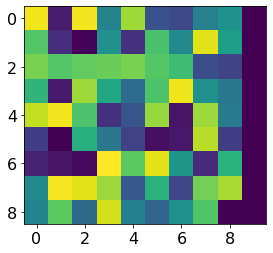

In [50]:
plt.imshow(np.asarray(hMidx[:,:,0]))

In [41]:
def leapfrog_functions_defs(
    u: gtscript.Field[float], 
    v: gtscript.Field[float], 
    phi_old: gtscript.Field[float], 
    phi_now: gtscript.Field[float],
    phi_new: gtscript.Field[float],
    *,
    dt: float,
    dx: float,
    dy: float
):
    from __gtscript__ import PARALLEL, computation, interval
    
    with computation(PARALLEL), interval(...):
        phi_new = phi_old - 2.0 * dt * (u + v)
        
        
        
    
        
        

In [42]:
leapfrog_functions = gtscript.stencil(
    definition=leapfrog_functions_defs, 
    backend=backend, 
)

In [ ]:
        # --- Compute mid-point values after half timestep --- #

        # Mid-point value for h along x
        hMidx = 0.5 * (h[1:,1:-1] + h[:-1,1:-1]) - \
             0.5 * self.dt / self.dx[:,1:-1] * (hu[1:,1:-1] - hu[:-1,1:-1])

        # Mid-point value for h along y
        hMidy = 0.5 * (h[1:-1,1:] + h[1:-1,:-1]) - \
             0.5 * self.dt / self.dy1[1:-1,:] * (hv1[1:-1,1:] - hv1[1:-1,:-1])

        # Mid-point value for hu along x
        Ux = hu * u + 0.5 * self.g * h * h
        huMidx = 0.5 * (hu[1:,1:-1] + hu[:-1,1:-1]) - \
                0.5 * self.dt / self.dx[:,1:-1] * (Ux[1:,1:-1] - Ux[:-1,1:-1]) + \
                0.5 * self.dt * \
                (0.5 * (self.f[1:,1:-1] + self.f[:-1,1:-1]) + \
                0.5 * (self.u[1:,1:-1] + self.u[:-1,1:-1]) * self.tgMidx / self.a) * \
                (0.5 * (hv[1:,1:-1] + hv[:-1,1:-1]))

        # Mid-point value for hu along y
        Uy = hu * v1
        huMidy = 0.5 * (hu[1:-1,1:] + hu[1:-1,:-1]) - \
                0.5 * self.dt / self.dy1[1:-1,:] * (Uy[1:-1,1:] - Uy[1:-1,:-1]) + \
                0.5 * self.dt * \
                (0.5 * (self.f[1:-1,1:] + self.f[1:-1,:-1]) + \
                0.5 * (u[1:-1,1:] + u[1:-1,:-1]) * self.tgMidy / self.a) * \
                (0.5 * (hv[1:-1,1:] + hv[1:-1,:-1]))

        # Mid-point value for hv along x
        Vx = hu * v
        hvMidx = 0.5 * (hv[1:,1:-1] + hv[:-1,1:-1]) - \
                0.5 * self.dt / self.dx[:,1:-1] * (Vx[1:,1:-1] - Vx[:-1,1:-1]) - \
                0.5 * self.dt * \
                (0.5 * (self.f[1:,1:-1] + self.f[:-1,1:-1]) + \
                0.5 * (u[1:,1:-1] + u [:-1,1:-1]) * self.tgMidx / self.a) * \
                (0.5 * (hu[1:,1:-1] + hu[:-1,1:-1]))

        # Mid-point value for hv along y
        Vy1 = hv * v1
        Vy2 = 0.5 * self.g * h * h
        hvMidy = 0.5 * (hv[1:-1,1:] + hv[1:-1,:-1]) - \
                0.5 * self.dt / self.dy1[1:-1,:] * (Vy1[1:-1,1:] - Vy1[1:-1,:-1]) - \
                0.5 * self.dt / self.dy[1:-1,:] * (Vy2[1:-1,1:] - Vy2[1:-1,:-1]) - \
                0.5 * self.dt * \
                (0.5 * (self.f[1:-1,1:] + self.f[1:-1,:-1]) + \
                0.5 * (u[1:-1,1:] + u[1:-1,:-1]) * self.tgMidy / self.a) * \
                (0.5 * (hu[1:-1,1:] + hu[1:-1,:-1]))

        # --- Compute solution at next timestep --- #

        # Update fluid height
        hnew = h[1:-1,1:-1] - \
               self.dt / self.dxc * (huMidx[1:,:] - huMidx[:-1,:]) - \
               self.dt / self.dy1c * (hvMidy[:,1:]*self.cMidy[:,1:] - hvMidy[:,:-1]*self.cMidy[:,:-1])